## Setup

In [107]:
# install dependencies
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

In [108]:
# variables
KURTOSIS_WINDOW = "1800D"
DATA_FILE = 'crsp.csv'
FAMA_FRENCH_FACTORS = 'F-F_Research_Data_Factors.csv'

In [109]:
# preprocessing

src = pd.read_csv(DATA_FILE)

src = src[['permno', 'comnam', 'date', 'prc', 'ret', 'dlret']]

src['ret'] = pd.to_numeric(src['ret'], errors='coerce')
src['date'] = pd.to_datetime(src['date'], format='%Y%m%d')

/tmp/ipykernel_4846/1447945420.py:3: DtypeWarning: Columns (5,6,7,10,18,38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  src = pd.read_csv(DATA_FILE)


## Experiment

In [110]:
def calculate_kurtosis(frame: pd.DataFrame):
    frame['kurtosis'] = None 

    for _, group in frame.groupby('permno'):
        k = group.set_index('date')['ret'].rolling(window=KURTOSIS_WINDOW).kurt()
        frame.loc[group.index, 'kurtosis'] = k.values

    return frame.dropna(subset=['kurtosis'])

In [111]:
# calculate kurtosis
df = calculate_kurtosis(src)

In [112]:
# Extract unique months
df['month_year'] = df['date'].dt.to_period('M')
df = df[df['month_year'] >= pd.Period('1926-07', freq='M')]
months = df['month_year'].unique()

/tmp/ipykernel_4846/1331480621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month_year'] = df['date'].dt.to_period('M')


##### Plotted curtosis of 15 stocks (1990-2025)

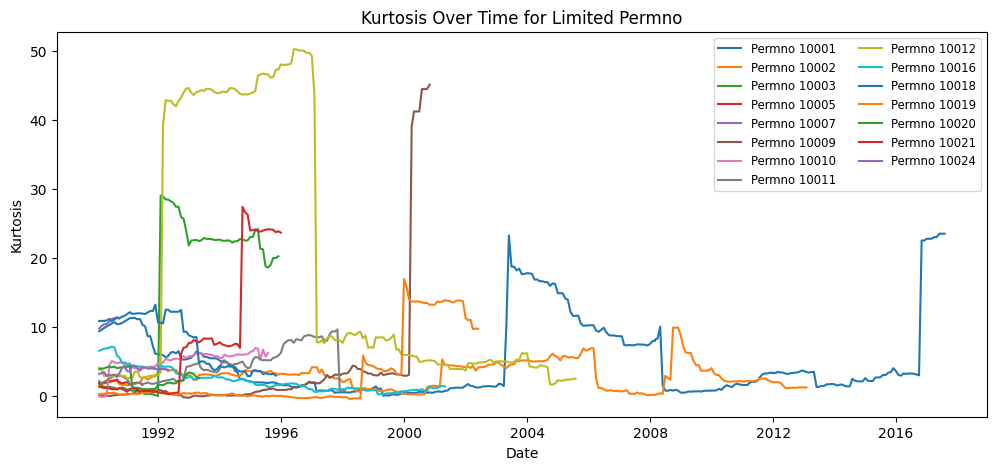

In [113]:
def plot_kurtosis_over_time_limited_filtered(data, limit=15):
    plt.figure(figsize=(12, 5))  
    filtered_data = data[(data['date'] >= '1990-01-01') & (data['date'] <= '2025-12-31')]
    for permno, group in filtered_data.groupby('permno'):
        plt.plot(group['date'], group['kurtosis'], label=f'Permno {permno}')
        limit -= 1
        if limit == 0:
            break
    plt.xlabel('Date')
    plt.ylabel('Kurtosis')
    plt.title('Kurtosis Over Time for Limited Permno')
    plt.legend(loc='upper right', fontsize='small', ncol=2)
    plt.show()

# Plot kurtosis 
plot_kurtosis_over_time_limited_filtered(df)

In [114]:
# autocorrelation of kurtosis

ac = []

for permno, group in df.groupby('permno'):
    group = group.set_index('month_year')
    ac.append(group["kurtosis"].autocorr(lag=1))

ac1 = pd.Series(ac).mean()

print("Mean autocorrelation of kurtosis: ", ac1)

/home/cgtnt/Petnica/CompFin2025/projekat/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3057: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/cgtnt/Petnica/CompFin2025/projekat/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/cgtnt/Petnica/CompFin2025/projekat/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/cgtnt/Petnica/CompFin2025/projekat/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/cgtnt/Petnica/CompFin2025/projekat/venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Mean autocorrelation of kurtosis:  0.820429535649931


High autocorrelation of kurtosis suggests it has potential to be used for signal construction.

##### Mean return of each quantile (all-time)

In [115]:
def assign_quantiles(data: pd.DataFrame, field):
    sorted_df = data.sort_values(by=field)
    sorted_df['quantile'] = pd.qcut(sorted_df[field], q=10, labels=False)
    return sorted_df

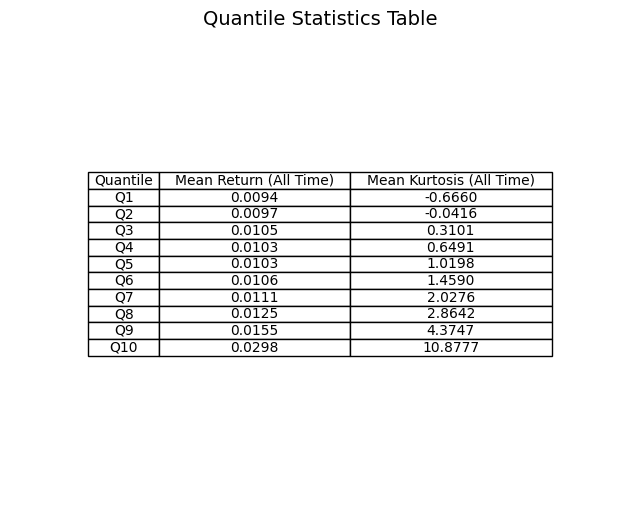

In [116]:
# measure mean return and mean kurtosis of quantiles through time 

quantile_means = []
quantile_kurtosis = []

for i in range(10):
    mean_returns = []
    mean_kurtosis = []

    # Iterate over unique months
    for month in months:
        month_data = df[df['month_year'] == month]
        quantiles = assign_quantiles(month_data, "kurtosis")

        mean_returns.append(quantiles[quantiles['quantile'] == i]['ret'].mean())
        mean_kurtosis.append(quantiles[quantiles['quantile'] == i]['kurtosis'].mean())

    quantile_means.append(pd.Series(mean_returns).mean())
    quantile_kurtosis.append(pd.Series(mean_kurtosis).mean())

# create table 
data = [[f"Q{i+1}", f"{quantile_means[i]:.4f}", f"{quantile_kurtosis[i]:.4f}"] for i in range(10)]

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('tight')
ax.axis('off')

table = ax.table(
    cellText=data,
    colLabels=["Quantile", "Mean Return (All Time)", "Mean Kurtosis (All Time)"],
    loc="center",
    cellLoc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(data[0]))))

plt.title("Quantile Statistics Table", fontsize=14)
plt.show()

Appears that quantiles with higher curtosis, when viewed as portfolios, perform better than quantiles with lower curtosis.

#### Portfolio generation 

In [117]:
# creating portfolios for next month
def create_portfolio(data: pd.DataFrame, long: list, short: list):
    quantiles = assign_quantiles(data, "kurtosis")

    # Create long portfolio
    long_portfolio = pd.concat(
        quantiles[quantiles['quantile'] == q].assign(position="long") for q in long
    )

    # Create short portfolio
    short_portfolio = pd.concat(
        quantiles[quantiles['quantile'] == q].assign(position="short") for q in short
    )

    # Combine long and short portfolios
    portfolio = pd.concat([long_portfolio, short_portfolio])
    portfolio = portfolio[['permno', 'comnam', 'month_year', 'position']] 

    return portfolio

# get return in next month
def get_return(portfolio: pd.DataFrame, next_month: pd.DataFrame):
    # Merge portfolio with next month's data
    portfolio = pd.merge(portfolio, next_month[['permno', 'ret', 'dlret']], on='permno', how='left')

    # Convert returns to numeric and handle missing values
    portfolio['ret'] = pd.to_numeric(portfolio['ret'], errors='coerce')
    portfolio['next_month_return'] = portfolio['ret'].fillna(portfolio['dlret'])

    # Negate returns for short positions
    portfolio.loc[portfolio['position'] == 'short', 'next_month_return'] *= -1

    # Return the mean of next month's returns
    return portfolio['next_month_return'].mean()


In [118]:
# Generate time series for port_small and port_large
portfolio_small_returns = []
portfolio_large_returns = []
quantile_returns = {q: [] for q in range(10)}

for month in months[:-1]:
    next_month = month + 1

    month_data = df[df['month_year'] == month]
    next_month_data = df[df['month_year'] == next_month]

    month_data = assign_quantiles(month_data, "kurtosis")

    portfolio_small = create_portfolio(month_data, [9], [0])
    portfolio_large = create_portfolio(month_data, [9, 8], [0, 1])

    # get quantile and portfolio returns
    for q in range(10):
        quantile_data = month_data[month_data['quantile'] == q]
        quantile_data = quantile_data.assign(position="long")
        quantile_returns[q].append(
            (next_month, get_return(quantile_data[['permno', 'comnam', 'month_year', 'position']], next_month_data))
        )

    portfolio_small_returns.append((next_month, get_return(portfolio_small, next_month_data)))
    portfolio_large_returns.append((next_month, get_return(portfolio_large, next_month_data)))

# Create time series
port_small_series = pd.Series(
    dict(portfolio_small_returns)
).sort_index()

port_large_series = pd.Series(
    dict(portfolio_large_returns)
).sort_index()

quantile_series = {
    q: pd.Series(dict(returns)).sort_index() for q, returns in quantile_returns.items()
}


/tmp/ipykernel_4846/1945758273.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio['next_month_return'] = portfolio['ret'].fillna(portfolio['dlret'])
/tmp/ipykernel_4846/1945758273.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  portfolio['next_month_return'] = portfolio['ret'].fillna(portfolio['dlret'])
/tmp/ipykernel_4846/1945758273.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future beha

In [119]:
# Export the entire quantile series to CSV
def export_quantile_series_to_csv(quantile_series, filename="quantile_series.csv"):
    # Create a DataFrame with all quantiles
    data = []
    for q, series in quantile_series.items():
        quantile_data = pd.DataFrame({
            "Month": series.index,
            "Quantile": f"Q{q+1}",
            "Return": series.values
        })
        data.append(quantile_data)
    
    # Concatenate all quantile data
    full_data = pd.concat(data, ignore_index=True)
    
    # Export to CSV
    full_data.to_csv(filename, index=False)
    print(f"Quantile series exported to {filename}")

# Example usage
export_quantile_series_to_csv(quantile_series, "quantile_series.csv")

Quantile series exported to quantile_series.csv


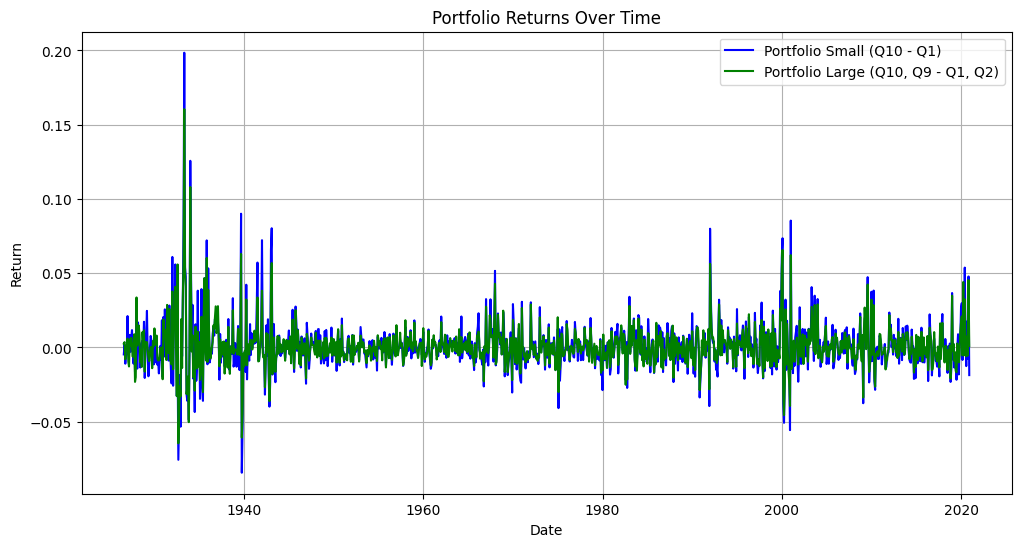

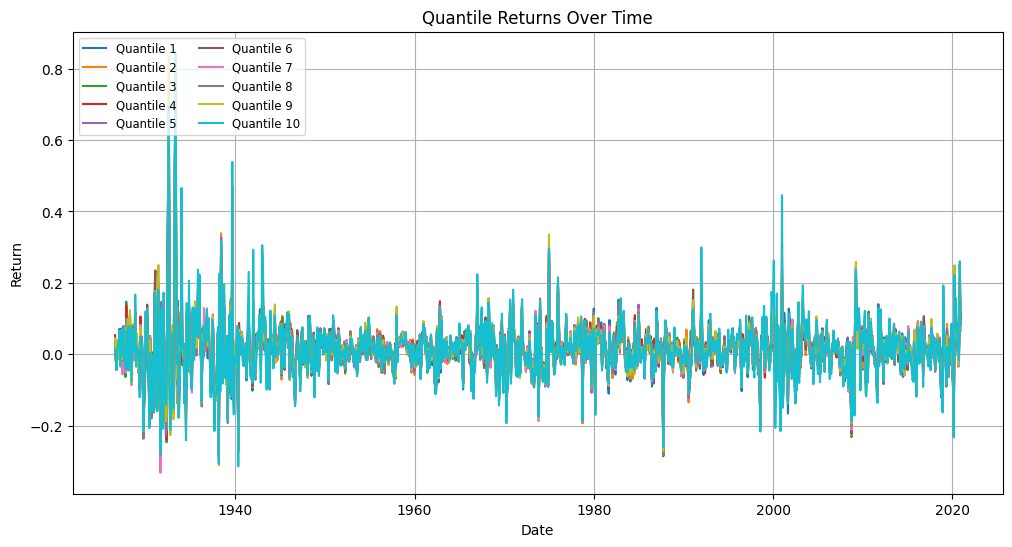

In [120]:
# Plot portfolio returns
plt.figure(figsize=(12, 6))
plt.plot(port_small_series.index.to_timestamp(), port_small_series.values, label="Portfolio Small (Q10 - Q1)", color="blue")
plt.plot(port_large_series.index.to_timestamp(), port_large_series.values, label="Portfolio Large (Q10, Q9 - Q1, Q2)", color="green")
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Portfolio Returns Over Time")
plt.legend()
plt.grid()
plt.show()

# Plot quantile returns_
plt.figure(figsize=(12, 6))
for q, series in quantile_series.items():
    plt.plot(series.index.to_timestamp(), series.values, label=f"Quantile {q+1}")
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Quantile Returns Over Time")
plt.legend(loc="upper left", fontsize="small", ncol=2)
plt.grid()
plt.show()

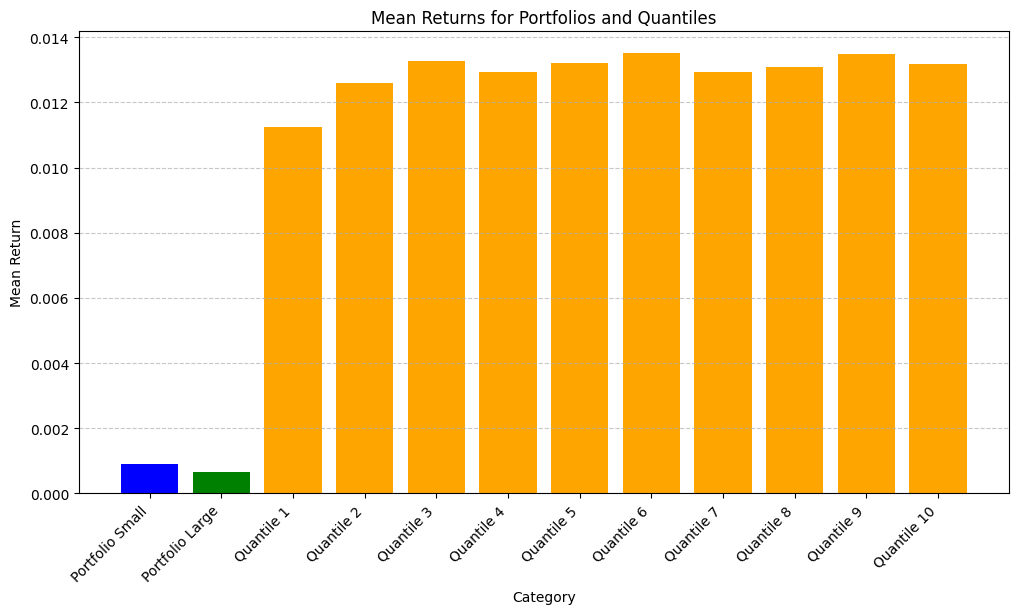

In [121]:
# plot mean return for each quantile and portfolio
mean_port_small = port_small_series.mean()
mean_port_large = port_large_series.mean()
mean_quantiles = {q: series.mean() for q, series in quantile_series.items()}

labels = ["Portfolio Small", "Portfolio Large"] + [f"Quantile {q+1}" for q in range(10)]
means = [mean_port_small, mean_port_large] + [mean_quantiles[q] for q in range(10)]

# Create bar chart
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=["blue", "green"] + ["orange"] * 10)
plt.xlabel("Category")
plt.ylabel("Mean Return")
plt.title("Mean Returns for Portfolios and Quantiles")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

#### Portfolio evaluation

In [122]:
# load fama french factors
ff_factors = pd.read_csv(FAMA_FRENCH_FACTORS)

ff_factors['month_year'] = pd.to_datetime(ff_factors['Date'], format='%Y%m').dt.to_period('M')
ff_factors = ff_factors[['month_year', 'MKT_RF', 'SMB', 'HML', 'RF']]

# Adjust scale of factors
ff_factors['MKT_RF'] = ff_factors['MKT_RF'] / 100
ff_factors['SMB'] = ff_factors['SMB'] / 100
ff_factors['HML'] = ff_factors['HML'] / 100
ff_factors['RF'] = ff_factors['RF'] / 100

In [123]:
def print_alpha(model, desc):
    print(f"{desc} - Alpha: {model.params['const']:.4f}, t-stat: {model.tvalues['const']:.4f}")

# define famma french
def fama_french(data: pd.Series, factors):
    # Load Fama-French factors
    data = data.reset_index()  
    data.columns = ['month_year', 'ret']  

    # match date with factors
    factors = factors[factors['month_year'].isin(data['month_year'])]
    data = data[data['month_year'].isin(factors['month_year'])]
    regression_in = pd.merge(data, factors, on='month_year', how='left')

    # Compute excess return
    regression_in['excess_return'] = regression_in['ret'] - regression_in['RF']

    # Prepare regression variables
    X = regression_in[['MKT_RF', 'SMB', 'HML']]
    X = X.apply(pd.to_numeric, errors='raise')
    X = sm.add_constant(X, has_constant='add')

    y = pd.to_numeric(regression_in['excess_return'], errors='raise')
    regression_in['excess_return'] = regression_in['ret'] - regression_in['RF']

    # Run regression
    model = sm.OLS(y, X).fit()
    return model

def capm(data: pd.Series, factors):
    # Load Fama-French factors
    data = data.reset_index()  
    data.columns = ['month_year', 'ret']  

    # match date with factors
    factors = factors[factors['month_year'].isin(data['month_year'])]
    regression_in = pd.merge(data, factors, on='month_year', how='left')

    # Compute excess return
    regression_in['excess_return'] = regression_in['ret'] - regression_in['RF']

    # Prepare regression variables
    X = sm.add_constant(regression_in['MKT_RF'], has_constant='add')
    y = pd.to_numeric(regression_in['excess_return'], errors='raise')

    # Run regression
    model = sm.OLS(y, X).fit()
    return model

In [124]:

# find alphas for portfolios
portfolio_small_model = fama_french(port_small_series, ff_factors)
portfolio_large_model = fama_french(port_large_series, ff_factors)

print_alpha(portfolio_small_model, f"Portfolio small (long Q10, short Q1)")
print_alpha(portfolio_large_model, f"Portfolio large (long Q10, Q9, short Q1, Q2)")

portfolio_alphas = [portfolio_small_model.params['const'], portfolio_large_model.params['const']]
quantile_alphas = []

portfolio_tvalues = [
    portfolio_small_model.tvalues['const'],
    portfolio_large_model.tvalues['const']
]
quantile_tvalues = []

# find alphas for quantiles
for q in range(10):
    model = fama_french(quantile_series[q], ff_factors)
    quantile_alphas.append(model.params['const'])
    quantile_tvalues.append(model.tvalues['const'])
    print_alpha(model, f"Quantile {q+1}")

Portfolio small (long Q10, short Q1) - Alpha: -0.0026, t-stat: -5.8826
Portfolio large (long Q10, Q9, short Q1, Q2) - Alpha: -0.0027, t-stat: -7.8260
Quantile 1 - Alpha: -0.0007, t-stat: -1.2758
Quantile 2 - Alpha: 0.0007, t-stat: 1.6748
Quantile 3 - Alpha: 0.0012, t-stat: 2.5718
Quantile 4 - Alpha: 0.0009, t-stat: 2.1047
Quantile 5 - Alpha: 0.0009, t-stat: 1.8712
Quantile 6 - Alpha: 0.0010, t-stat: 1.9999
Quantile 7 - Alpha: 0.0006, t-stat: 1.1792
Quantile 8 - Alpha: 0.0007, t-stat: 1.3284
Quantile 9 - Alpha: 0.0005, t-stat: 0.7618
Quantile 10 - Alpha: -0.0003, t-stat: -0.3874


In [125]:
# find betas for portfolios
portfolio_small_beta_model = capm(port_small_series, ff_factors)
portfolio_large_beta_model = capm(port_large_series, ff_factors)

print_alpha(portfolio_small_beta_model, f"Portfolio small (long Q10, short Q1)")
print_alpha(portfolio_large_beta_model, f"Portfolio large (long Q10, Q9, short Q1, Q2)")

portfolio_betas = [portfolio_small_beta_model.params['MKT_RF'], portfolio_large_beta_model.params['MKT_RF']]
quantile_betas = []

portfolio_tvalues_beta = [
    portfolio_small_beta_model.tvalues['MKT_RF'],
    portfolio_large_beta_model.tvalues['MKT_RF']
]
quantile_tvalues_beta = []

# find betas for quantiles
for q in range(10):
    model = capm(quantile_series[q], ff_factors)
    quantile_betas.append(model.params['MKT_RF'])
    quantile_tvalues_beta.append(model.tvalues['MKT_RF'])


Portfolio small (long Q10, short Q1) - Alpha: -0.0020, t-stat: -3.8980
Portfolio large (long Q10, Q9, short Q1, Q2) - Alpha: -0.0023, t-stat: -5.3469


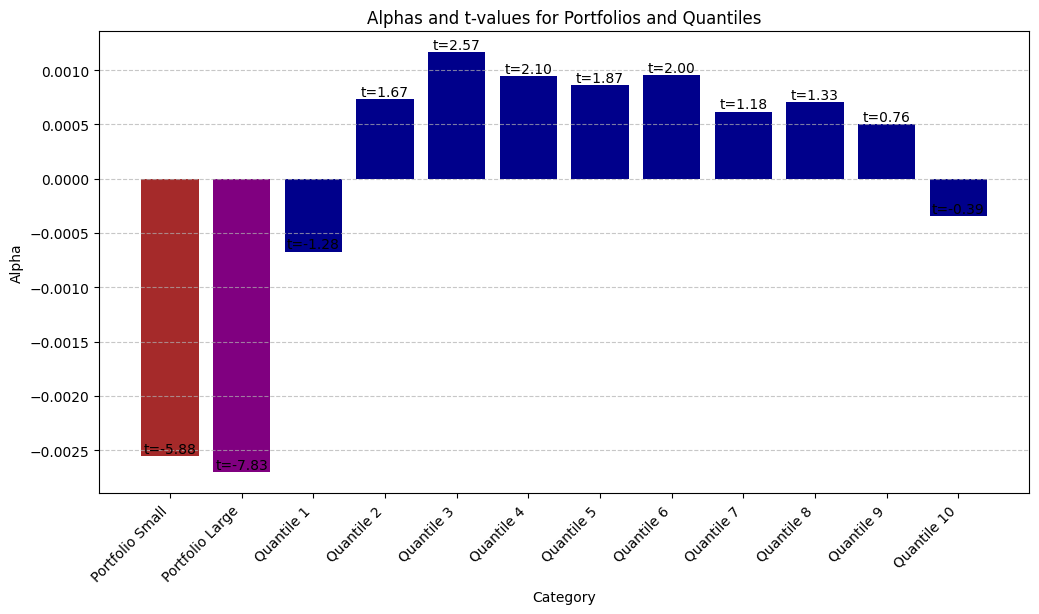

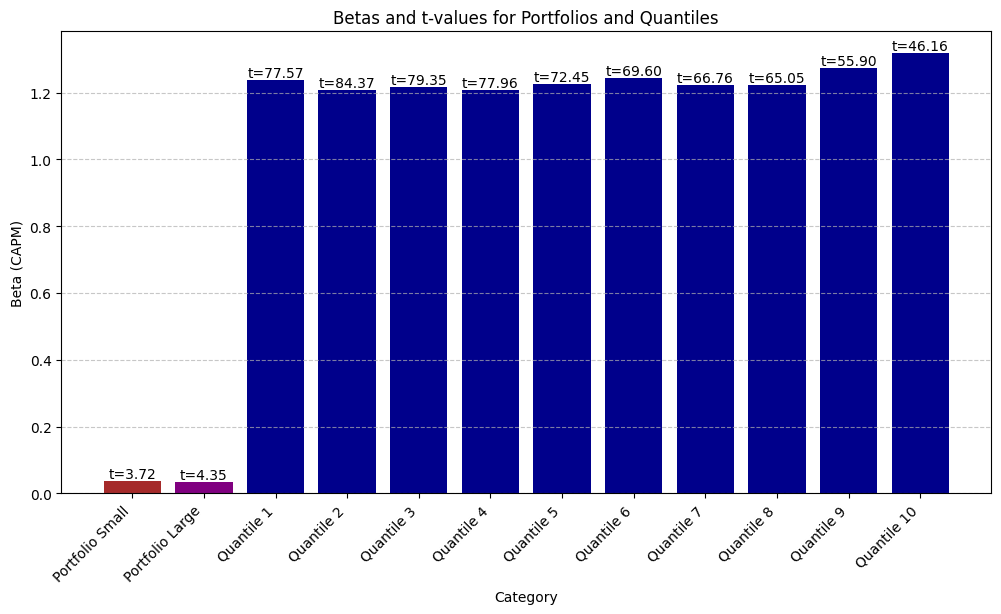

In [126]:
# create charts for alphas
labels = ["Portfolio Small", "Portfolio Large"] + [f"Quantile {q+1}" for q in range(10)]
alphas = portfolio_alphas + quantile_alphas
tvalues = portfolio_tvalues + quantile_tvalues

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, alphas, color=["brown", "purple"] + ["darkblue"] * 10)

for bar, alpha, tvalue in zip(bars, alphas, tvalues):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"t={tvalue:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xlabel("Category")
plt.ylabel("Alpha")
plt.title("Alphas and t-values for Portfolios and Quantiles")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# create charts for betas
labels = ["Portfolio Small", "Portfolio Large"] + [f"Quantile {q+1}" for q in range(10)]
betas = portfolio_betas + quantile_betas
tvalues_beta = portfolio_tvalues_beta + quantile_tvalues_beta

plt.figure(figsize=(12, 6))
bars = plt.bar(labels, betas, color=["brown", "purple"] + ["darkblue"] * 10)

for bar, beta, tvalue in zip(bars, betas, tvalues_beta):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"t={tvalue:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.xlabel("Category")
plt.ylabel("Beta (CAPM)")
plt.title("Betas and t-values for Portfolios and Quantiles")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [127]:
# define sharpe ratio
def sharpe_ratio(data: pd.Series, factors):
    data = data.reset_index()  
    data.columns = ['month_year', 'ret']  

    # match date with factors
    factors = factors[factors['month_year'].isin(data['month_year'])]
    returns_in = pd.merge(data, factors, on='month_year', how='left')

    # Compute excess return
    returns_in['excess_return'] = returns_in['ret'] - returns_in['RF']

    # return sharpe ratio
    return returns_in['excess_return'].mean() / returns_in['excess_return'].std() * np.sqrt(12)

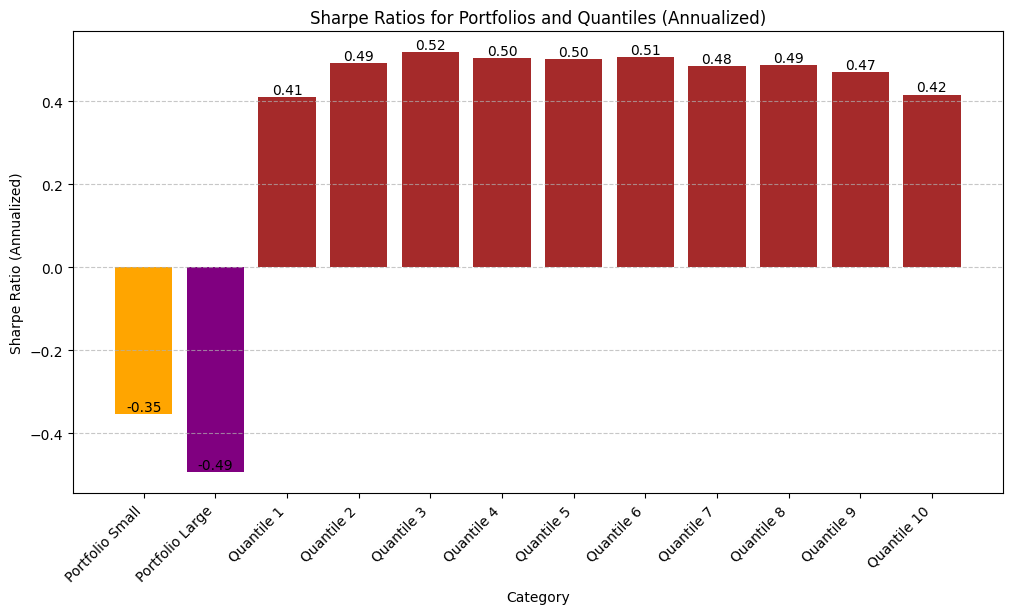

In [128]:
# calculate sharpe ratio for portfolios and quantiles
portfolio_small_sharpe = sharpe_ratio(port_small_series, ff_factors)
portfolio_large_sharpe = sharpe_ratio(port_large_series, ff_factors)
quantile_sharpe = [sharpe_ratio(quantile_series[q], ff_factors) for q in range(10)]

# create bar chart for sharpe ratio
labels = ["Portfolio Small", "Portfolio Large"] + [f"Quantile {q+1}" for q in range(10)]
sharpe_values = [portfolio_small_sharpe, portfolio_large_sharpe] + quantile_sharpe   
plt.figure(figsize=(12, 6))
bars = plt.bar(labels, sharpe_values, color=["orange", "purple"] + ["brown"] * 10)
for bar, tvalue in zip(bars, sharpe_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{tvalue:.2f}",
        ha="center",
        va="bottom",
        fontsize=10
    )
plt.xlabel("Category")
plt.ylabel("Sharpe Ratio (Annualized)")
plt.title("Sharpe Ratios for Portfolios and Quantiles (Annualized)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

##### Misc

In [129]:
# generate portfolio for next month (from now)
month = months[-1]
month_data = df[df['month_year'] == month]

portfolio_small = create_portfolio(month_data, [9], [0])
portfolio_large = create_portfolio(month_data, [9,8], [0,1])

print("Portfolio Small:", portfolio_small.head())
print("Portfolio Large:", portfolio_large.head())

Portfolio Small:          permno                     comnam month_year position
3587612   14238  AERIE PHARMACEUTICALS INC    2020-12     long
3589757   79499               INNODATA INC    2020-12     long
3589245   45728              INVACARE CORP    2020-12     long
3587481   13534   HOMETRUST BANCSHARES INC    2020-12     long
3589270   47730       A B M INDUSTRIES INC    2020-12     long
Portfolio Large:          permno                     comnam month_year position
3587612   14238  AERIE PHARMACEUTICALS INC    2020-12     long
3589757   79499               INNODATA INC    2020-12     long
3589245   45728              INVACARE CORP    2020-12     long
3587481   13534   HOMETRUST BANCSHARES INC    2020-12     long
3589270   47730       A B M INDUSTRIES INC    2020-12     long
